# Predicting Default Credit Cards Clients

A bank in you region want to build a model to predict credit card defaulters more accurately in order minimize money loss. For this task we have a set of data on default payments and demographic data to help us do our task. Data is comprised in the following CSV files:


**TRAINING**

**`train_customers.csv`**
 - `ID`: ID of each client
 - `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
 - `SEX`: Gender (1=male, 2=female)
 - `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
 - `MARRIAGE`: Marital status (1=married, 2=single, 3=others)
 - `AGE`: Age in years
 
**`train_series.csv`**
 - `ID`: ID of each client
 - `MONTH`: The month to wich data is refering
 - `PAY`: Repayment status in the corresponding month (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
 - `BILL_AMT`: Amount of bill statement in the corresponding month (NT dollar)
 - `PAY_AMT`: Amount of previous payment in the corresponding month (NT dollar)
 
**`train_target.csv`**
 - `DEFAULT_JULY`: Default payment in July (1=yes, 0=no)
 
 
**TEST** 
 - **`test_data.csv`**
 
**SUBMISSION** 
 - **`submission_features.csv`**

# Table of Contents
- [A. Data Engineering](#1) 
    - [Question 1](#1.1) 
    - [Question 2](#1.2) 
    - [Question 3](#1.3) 
- [B. Exploratory Data Analysis](#2) 
    - [Question 1](#2.1) 
    - [Question 2](#2.2) 
    - [Question 3](#2.3)
- [C. Exploratory Data Analysis](#3)  
    - [Question 1](#3.1)
        - [Prepare Train & Test Set](#3.1.1)
        - [Feature Engineer Training Set](#3.1.2)
        - [Feature Engineer Test Set](#3.1.3)
        - [Define Column Types](#3.1.4)
        - [Extreme Value Removal](#3.1.5)
        - [Create X_train & y_train](#3.1.6)
        - [Create X_test & y_test](#3.1.7)
        - [Modelling: Logistic Regression & LDA](#3.1.8)
        - [Modelling: Random Forest](#3.1.9)
        - [Modelling: Random Forest with Bagging](#3.1.10)
        - [Modelling: XGBoost](#3.1.11)
        - [Modelling: Final Model](#3.1.12)
            - [Prepare Submission File](#3.1.12.1)
            - [Run Final Model](#3.1.12.2)
    - [Question 2](#3.2) 
    - [Question 3](#3.3)

<a id='1'></a> 
## A. DATA ENGINEERING

Here, I will create the final dataset to be used for training. This involves the following steps:
1. Load the train_series.csv file and pivot the time-dependent columns (PAY, BILL_AMT, and PAY_AMT) to build one column of these per month. (Ex. PAY_JUNE, PAY_MAY, ..., BILL_AMT_JUNE, ...).
2. Load train_customers.csv and include the pivoted table of time series data. The resulting table must be a table with one row per customer (ID).
3. Include information from the target (train_target.csv) on the table.

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
#Load train_series
train_series = pd.read_csv("train_series.csv")

In [4]:
train_series.sort_values("ID").head()

,ID,MONTH,PAY,BILL_AMT,PAY_AMT
68556,0,JUNE,-1.0,28991.0,1300.0
68558,0,APRIL,0.0,13600.0,0.0
68559,0,MARCH,0.0,0.0,22373.0
68560,0,FEBRUARY,-1.0,44024.0,680.0
68561,0,JANUARY,0.0,18697.0,10000.0


In [5]:
#pivot train_series
train_pivot = train_series.pivot_table(
    index="ID",
    columns=["MONTH"],
    values=["PAY", "BILL_AMT", "PAY_AMT"]
)

In [6]:
#Inspect train_series
train_pivot.head()

BILL_AMT                                                     PAY  \
MONTH     APRIL  FEBRUARY   JANUARY      JUNE     MARCH       MAY APRIL   
ID                                                                        
0       13600.0   44024.0   18697.0   28991.0       0.0   24391.0   0.0   
1       53169.0   50372.0   49470.0   75662.0   50875.0   70073.0   0.0   
2      161487.0  168094.0  170922.0  155910.0  157577.0  158819.0   2.0   
3           0.0       0.0       0.0   23570.0       0.0     735.0  -2.0   
4        9044.0    9417.0    9617.0    8214.0    9225.0    8034.0   0.0   

                                       PAY_AMT                            \
MONTH FEBRUARY JANUARY JUNE MARCH  MAY   APRIL FEBRUARY  JANUARY    JUNE   
ID                                                                         
0         -1.0     0.0 -1.0   0.0  0.0     0.0    680.0  10000.0  1300.0   
1          0.0     0.0  0.0   0.0  0.0  2000.0   1903.0   2006.0  3212.0   
2          2.0     2.0  2.0   2.0  2.0     0.0   5500.0   1000.0  6800.0   
3         -2.0    -2.0 -2.0  -2.0 -2.0     0.0      0.0      0.0   742.0   
4          0.0     0.0  0.0   0.0  0.0   331.0    356.0    330.0  1140.0   

                        
MONTH    MARCH     MAY  
ID                      
0      22373.0  1000.0  
1       1603.0  2106.0  
2      13000.0  6500.0  
3          0.0     0.0  
4        341.0  1150.0

In [7]:
#Load customer data
customers = pd.read_csv("train_customers.csv")

In [8]:
#Inspect customer data
customers.sort_values('ID').head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
11426,0,40000.0,2,2,2,26
16839,1,80000.0,2,3,1,59
3844,2,170000.0,2,1,2,30
6157,3,200000.0,2,2,1,41
10924,4,50000.0,1,2,1,43


In [9]:
#Join train series & customer data
train = pd.merge(train_pivot, customers, on='ID')

/var/folders/f6/n4pnylls119_nbw8y633bg_40000gn/T/ipykernel_37917/2740619096.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  train = pd.merge(train_pivot, customers, on='ID')


In [10]:
#Rename train columns
train = train.rename(columns={
                        train.columns[1]: 'BILL_AMT_APRIL',
                        train.columns[2]: 'BILL_AMT_FEBRUARY',
                        train.columns[3]: 'BILL_AMT_JANUARY',
                        train.columns[4]: 'BILL_AMT_JUNE',
                        train.columns[5]: 'BILL_AMT_MARCH',
                        train.columns[6]: 'BILL_AMT_MAY',
                        train.columns[7]: 'PAY_APRIL',
                        train.columns[8]: 'PAY_FEBRUARY',
                        train.columns[9]: 'PAY_JANUARY',
                        train.columns[10]: 'PAY_JUNE',
                        train.columns[11]: 'PAY_MARCH',
                        train.columns[12]: 'PAY_MAY',
                        train.columns[13]: 'PAY_AMT_APRIL',
                        train.columns[14]: 'PAY_AMT_FEBRUARY',
                        train.columns[15]: 'PAY_AMT_JANUARY',
                        train.columns[16]: 'PAY_AMT_JUNE',
                        train.columns[17]: 'PAY_AMT_MARCH',
                        train.columns[18]: 'PAY_AMT_MAY',
                       })

In [11]:
train.head(3)

,ID,BILL_AMT_APRIL,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,BILL_AMT_JUNE,BILL_AMT_MARCH,BILL_AMT_MAY,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,...,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
0,0,13600.0,44024.0,18697.0,28991.0,0.0,24391.0,0.0,-1.0,0.0,...,680.0,10000.0,1300.0,22373.0,1000.0,40000.0,2,2,2,26
1,1,53169.0,50372.0,49470.0,75662.0,50875.0,70073.0,0.0,0.0,0.0,...,1903.0,2006.0,3212.0,1603.0,2106.0,80000.0,2,3,1,59
2,2,161487.0,168094.0,170922.0,155910.0,157577.0,158819.0,2.0,2.0,2.0,...,5500.0,1000.0,6800.0,13000.0,6500.0,170000.0,2,1,2,30


In [12]:
#Load target
target = pd.read_csv("train_target.csv")

In [13]:
#Inspect target
target.sort_values("ID").head()

,ID,DEFAULT_JULY
11426,0,0
16839,1,0
3844,2,1
6157,3,1
10924,4,0


In [14]:
#Join final train with target
final_train = pd.merge(train, target, on="ID")

In [15]:
final_train.sort_values("ID").head(3)

,ID,BILL_AMT_APRIL,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,BILL_AMT_JUNE,BILL_AMT_MARCH,BILL_AMT_MAY,PAY_APRIL,PAY_FEBRUARY,PAY_JANUARY,...,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,DEFAULT_JULY
0,0,13600.0,44024.0,18697.0,28991.0,0.0,24391.0,0.0,-1.0,0.0,...,10000.0,1300.0,22373.0,1000.0,40000.0,2,2,2,26,0
1,1,53169.0,50372.0,49470.0,75662.0,50875.0,70073.0,0.0,0.0,0.0,...,2006.0,3212.0,1603.0,2106.0,80000.0,2,3,1,59,0
2,2,161487.0,168094.0,170922.0,155910.0,157577.0,158819.0,2.0,2.0,2.0,...,1000.0,6800.0,13000.0,6500.0,170000.0,2,1,2,30,1


In [16]:
#Check for null values
final_train.isnull().sum()

ID                   0
BILL_AMT_APRIL       0
BILL_AMT_FEBRUARY    0
BILL_AMT_JANUARY     0
BILL_AMT_JUNE        0
BILL_AMT_MARCH       0
BILL_AMT_MAY         0
PAY_APRIL            0
PAY_FEBRUARY         0
PAY_JANUARY          0
PAY_JUNE             0
PAY_MARCH            0
PAY_MAY              0
PAY_AMT_APRIL        0
PAY_AMT_FEBRUARY     0
PAY_AMT_JANUARY      0
PAY_AMT_JUNE         0
PAY_AMT_MARCH        0
PAY_AMT_MAY          0
LIMIT_BAL            0
SEX                  0
EDUCATION            0
MARRIAGE             0
AGE                  0
DEFAULT_JULY         0
dtype: int64

In [17]:
final_train.to_csv("LeitaoBeatriz_A_train.csv")

<a id='2'></a>
## **B. EXPLORATORY DATA ANALYSIS (2 points)**

In [18]:
#Create df with number of defaultes for each level of education
ed_default = final_train.groupby("EDUCATION")["DEFAULT_JULY"].value_counts().to_frame().unstack().iloc[:,1]

In [19]:
ed_default

EDUCATION
0       NaN
1    1336.0
2    2225.0
3     836.0
4       6.0
5      15.0
6       2.0
Name: (DEFAULT_JULY, 1), dtype: float64

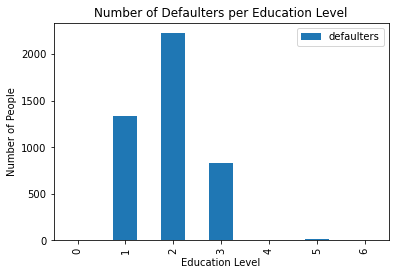

In [20]:
#Plot data
plot = ed_default.plot.bar()

plot.set_xlabel('Education Level')
plot.set_ylabel('Number of People')
plot.set_title('Number of Defaulters per Education Level')

plt.legend(labels=["defaulters"])

Insights from the plot above:
- Level of education 2 has the highest number of defaulters
- Level of education 0 has the lowest number of defaulters (none)
- The distribution of defaulters given education is skewed
- There are very little defaulters with higher levels of education (4-6). However, there are very little IDs in the training set with higher education levels so the ratio of non defaulters to defaulters at higher education levels may be similar to that of other education levels.
- There is very little data for 0 (not described in dataset description), 4 (others), 5 (unknown), and 6 (unknown) so might make sense to bin these.

In [21]:
#Create df for defaulters and non defaulters
non_defaulters = final_train.loc[final_train["DEFAULT_JULY"] == 0]
defaulters = final_train.loc[final_train["DEFAULT_JULY"] == 1]

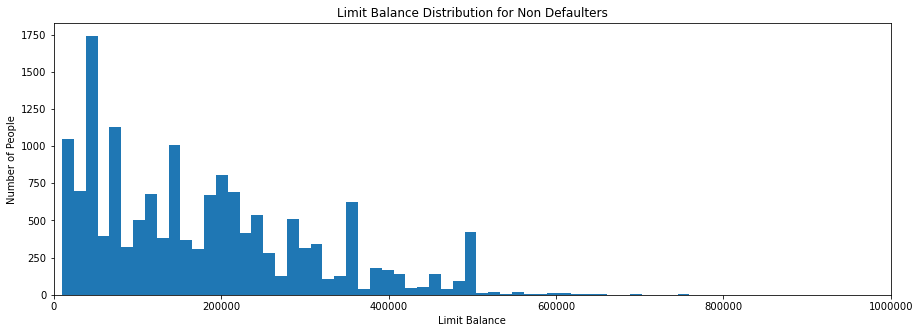

In [22]:
#Creating histogram of LIMIT_BAL for non defaulters
plot_2 = non_defaulters["LIMIT_BAL"].plot.hist(figsize=(15,5), bins=70)

plot_2.set_xlabel('Limit Balance')
plot_2.set_ylabel('Number of People')
plot_2.set_title('Limit Balance Distribution for Non Defaulters')
plot_2.set_xlim([0,1000000])
plot_2.ticklabel_format(style='plain', axis='x', scilimits=(0,0))

(-26500.0, 1000000.0)

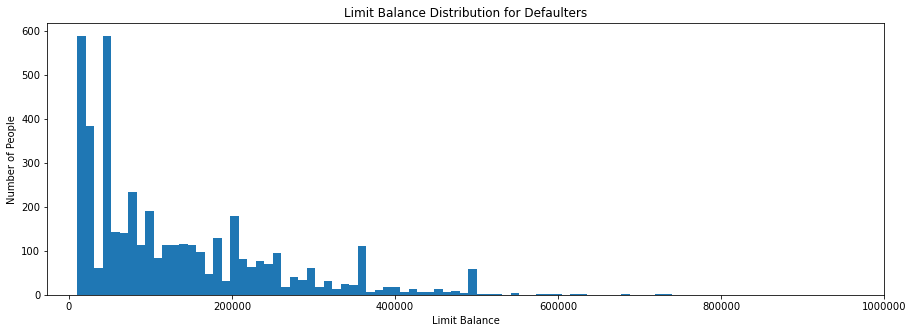

In [23]:
#Creating histogram of LIMIT_BAL for defaulters
plot_3 = defaulters["LIMIT_BAL"].plot.hist(figsize=(15,5), bins=70)

plot_3.set_xlabel('Limit Balance')
plot_3.set_ylabel('Number of People')
plot_3.set_title('Limit Balance Distribution for Defaulters')
plot_3.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
plot_3.set_xlim(right=1000000)

Insights from histograms above:
- Distribution for both defaulters & non-defaulters is skewed to the left but looks similar
- There are a lot more non-defaulters than defaulters
- There is an outlier representing a non fefaulter with a much higher limit balance than the rest
- Non defaulters have a higher maximum value of limit balance than defaulters

<AxesSubplot:>

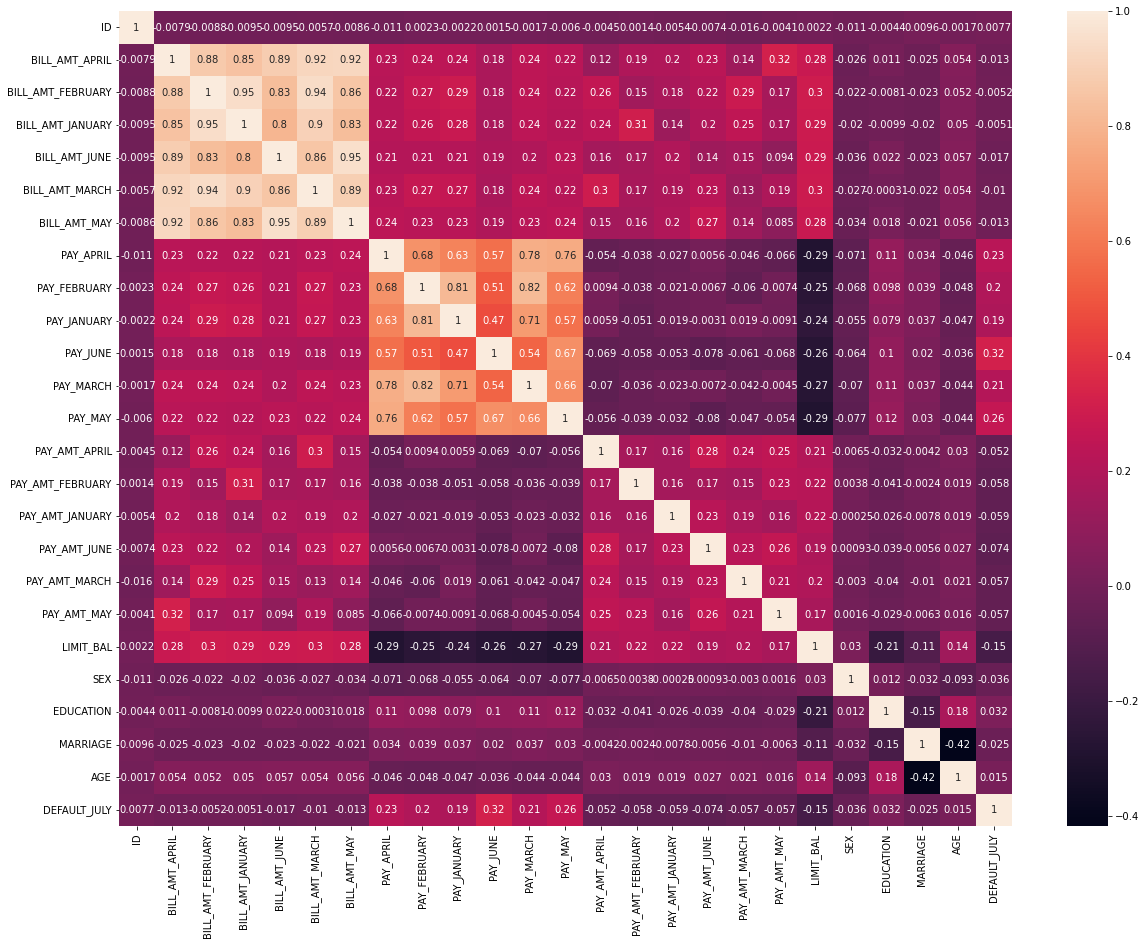

In [24]:
#Create correlation matrix
plt.figure(figsize=(20, 15))

sns.heatmap(final_train.corr(), annot=True)

Insights from plot above:
- No variables have a high correlation with the target variable
- The time series features of 'bill amounts' and 'pay' are highly correlated with themselves across months but 'pay amount' does not. 'Bill amounts' have the highest range of correlations (0.85 - 0.92) and 'pay' the second highest (0.57 - 0.78). If using logistic regression, high correlations should be removed

<AxesSubplot:ylabel='Frequency'>

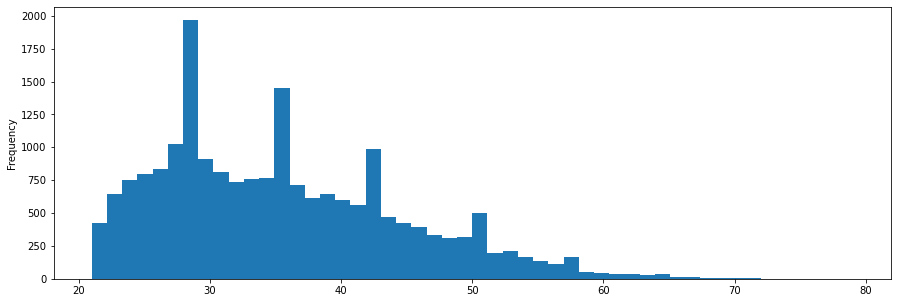

In [25]:
#Check age distribution
final_train["AGE"].plot.hist(figsize=(15, 5), bins=50)

Insights from plot above:
- Age distribution is skewed to the left with a lot more younger people than older people
- The highest spikes on the gaph shows that the age range with the most amount of people in the dataset is in the late 20s followed by the mid 30s and early mid 40s

In [26]:
#Marital status per defaulters
default_marriage = final_train.groupby("DEFAULT_JULY")["MARRIAGE"].value_counts().to_frame().unstack()#.iloc[1,:]

In [27]:
default_marriage

MARRIAGE                 
MARRIAGE            0     1     2    3
DEFAULT_JULY                          
0                  32  6991  8402  155
1                   4  2152  2203   61

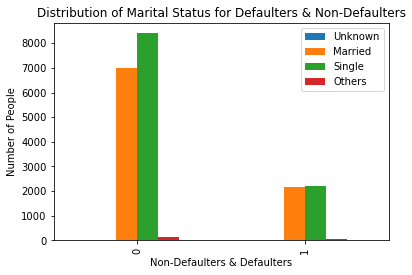

In [28]:
plot_4 = default_marriage.plot.bar()

plot_4.set_xlabel('Non-Defaulters & Defaulters')
plot_4.set_ylabel('Number of People')
plot_4.set_title('Distribution of Marital Status for Defaulters & Non-Defaulters')

plt.legend(labels=["Unknown", "Married", "Single", "Others"])

Insights from plot above:
- There are more single than married non-defaulters whereas the amount of defautlers that are marreid and single do not differ greatly
- There is an unknown marriage category with very little records, so if this featue is important in a model, could consider binning together 'unknown' with 'others' or removing rows for unknokwn as dataset is quite large.

<AxesSubplot:>

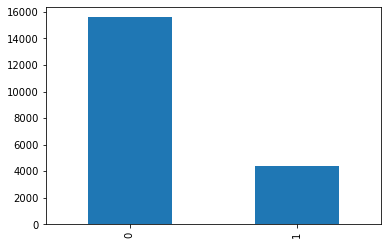

In [29]:
#Check if target class is unbalanced
final_train["DEFAULT_JULY"].value_counts().plot.bar()

Insights from plot above:
- Target variable is unbalanced. This needs to be considered when running models, either through statificatio or undersampling the majority class and oversampling the minority class.

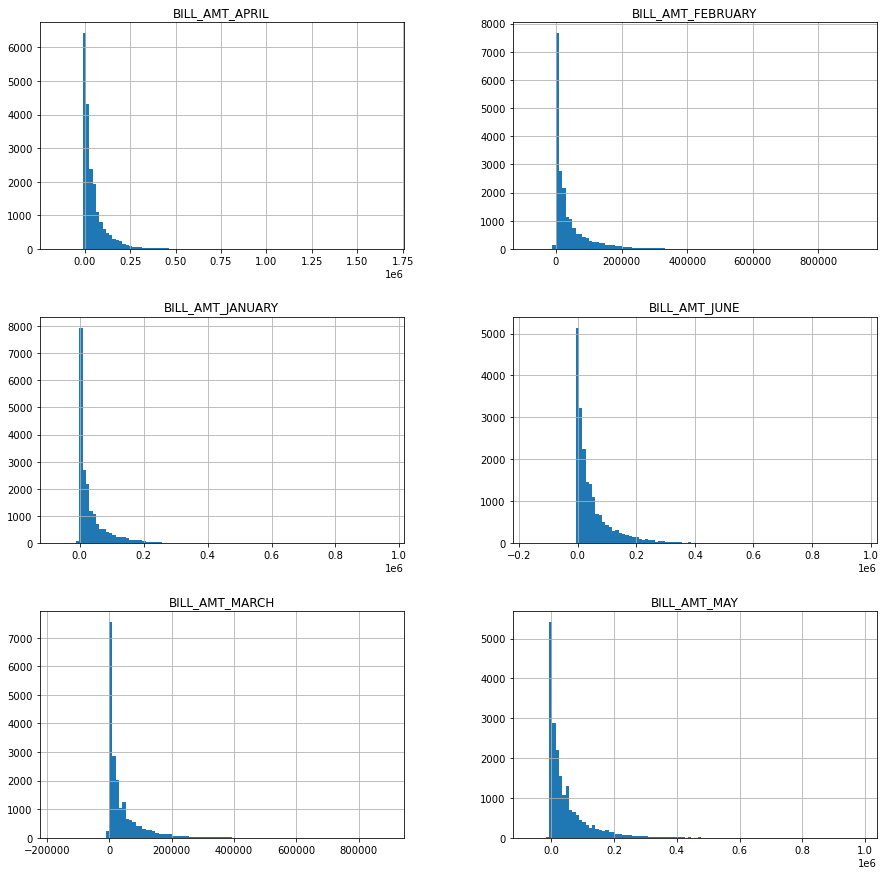

In [30]:
#Look at feature distribution of bill_amt
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
i = 1

for triaxis in axes:
    for axis in triaxis:
        train.hist(column = train.columns[i], bins = 100, ax=axis)
        i = i+1
        if i > 6:
            break

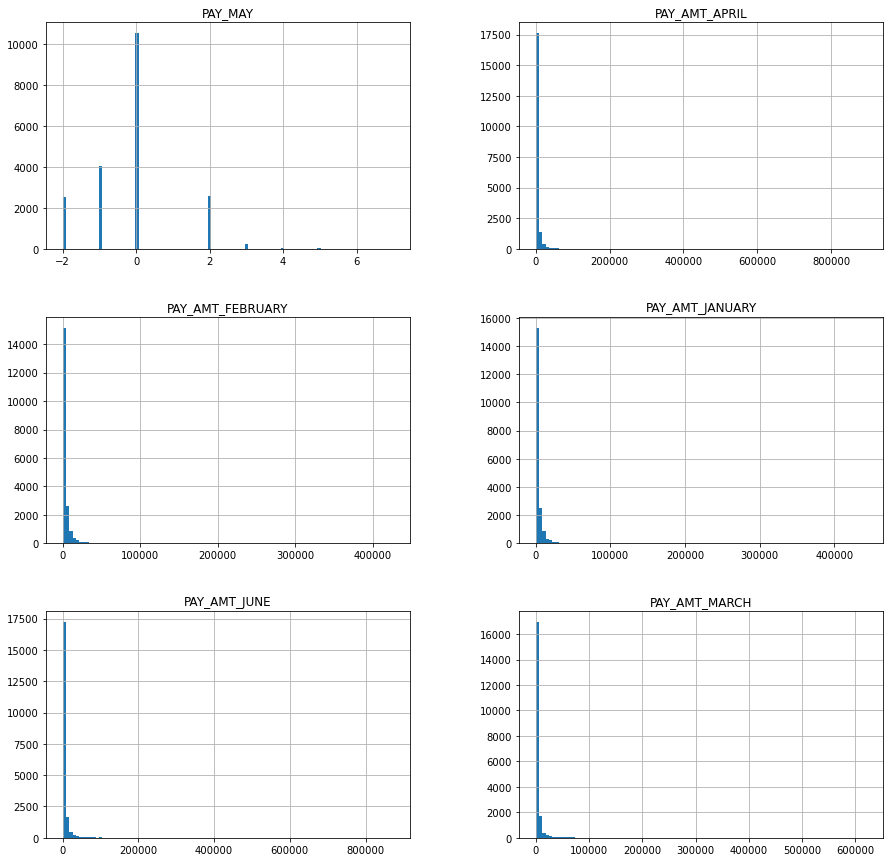

In [31]:
#Look at feature distribution of pay_amt
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
i = 12
for triaxis in axes:
    for axis in triaxis:
        train.hist(column = train.columns[i], bins = 100, ax=axis)
        i = i+1
        if i >= 18:
            break

Insights from plots above:
- Both bill_amt and pay_amt have very skewed distributions with some major outliers on the right.
- Could consider outlier removal 

In [32]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 20000 non-null  int64  
 1   BILL_AMT_APRIL     20000 non-null  float64
 2   BILL_AMT_FEBRUARY  20000 non-null  float64
 3   BILL_AMT_JANUARY   20000 non-null  float64
 4   BILL_AMT_JUNE      20000 non-null  float64
 5   BILL_AMT_MARCH     20000 non-null  float64
 6   BILL_AMT_MAY       20000 non-null  float64
 7   PAY_APRIL          20000 non-null  float64
 8   PAY_FEBRUARY       20000 non-null  float64
 9   PAY_JANUARY        20000 non-null  float64
 10  PAY_JUNE           20000 non-null  float64
 11  PAY_MARCH          20000 non-null  float64
 12  PAY_MAY            20000 non-null  float64
 13  PAY_AMT_APRIL      20000 non-null  float64
 14  PAY_AMT_FEBRUARY   20000 non-null  float64
 15  PAY_AMT_JANUARY    20000 non-null  float64
 16  PAY_AMT_JUNE       200

<a id='3'></a>
## **C. MACHINE LEARNING (5 points)**

In this part, I will build a machine learning models to estimate the probability of default of the customers. This requires 2 additional dataets:
1. test_data.csv - Contains new data from 9000 customers with the same structure as the final training data. This will be used as a validation set
2. submission_features.csv - Test set that contains data associated with unseen customers, but without the target. To be used to make predictions to upload to Kaggle.

<a id='3.1.1'></a>
### Prepare Train & Test Set

In [33]:
#Rorder training set cols
train = final_train.reindex(sorted(final_train.columns), axis=1)

In [34]:
#Load test set
test = pd.read_csv("test_data.csv")

#Reorder test set cols to amtch training set
test = test.reindex(sorted(test.columns), axis=1)

In [35]:
#View training set
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGE                20000 non-null  int64  
 1   BILL_AMT_APRIL     20000 non-null  float64
 2   BILL_AMT_FEBRUARY  20000 non-null  float64
 3   BILL_AMT_JANUARY   20000 non-null  float64
 4   BILL_AMT_JUNE      20000 non-null  float64
 5   BILL_AMT_MARCH     20000 non-null  float64
 6   BILL_AMT_MAY       20000 non-null  float64
 7   DEFAULT_JULY       20000 non-null  int64  
 8   EDUCATION          20000 non-null  int64  
 9   ID                 20000 non-null  int64  
 10  LIMIT_BAL          20000 non-null  float64
 11  MARRIAGE           20000 non-null  int64  
 12  PAY_AMT_APRIL      20000 non-null  float64
 13  PAY_AMT_FEBRUARY   20000 non-null  float64
 14  PAY_AMT_JANUARY    20000 non-null  float64
 15  PAY_AMT_JUNE       20000 non-null  float64
 16  PAY_AMT_MARCH      200

In [36]:
#View test set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGE                9000 non-null   int64  
 1   BILL_AMT_APRIL     9000 non-null   float64
 2   BILL_AMT_FEBRUARY  9000 non-null   float64
 3   BILL_AMT_JANUARY   9000 non-null   float64
 4   BILL_AMT_JUNE      9000 non-null   float64
 5   BILL_AMT_MARCH     9000 non-null   float64
 6   BILL_AMT_MAY       9000 non-null   float64
 7   DEFAULT_JULY       9000 non-null   int64  
 8   EDUCATION          9000 non-null   int64  
 9   ID                 9000 non-null   int64  
 10  LIMIT_BAL          9000 non-null   float64
 11  MARRIAGE           9000 non-null   int64  
 12  PAY_AMT_APRIL      9000 non-null   float64
 13  PAY_AMT_FEBRUARY   9000 non-null   float64
 14  PAY_AMT_JANUARY    9000 non-null   float64
 15  PAY_AMT_JUNE       9000 non-null   float64
 16  PAY_AMT_MARCH      9000 

In [37]:
list(train.iloc[:,18:24])


['PAY_APRIL',
 'PAY_FEBRUARY',
 'PAY_JANUARY',
 'PAY_JUNE',
 'PAY_MARCH',
 'PAY_MAY']

<a id='3.1.2'></a>
### Feature Engineer Training Set

In [38]:
# Define pay columns to use in feature engineering
pay_cols = ['PAY_APRIL',
 'PAY_FEBRUARY',
 'PAY_JANUARY',
 'PAY_JUNE',
 'PAY_MARCH',
 'PAY_MAY']

In [39]:
#Bin unknown marital status 'others' with 'unknown'
train.loc[train["MARRIAGE"] == 0, "MARRIAGE"] = 3

#Recode sex
train.loc[train["SEX"] == 2, "SEX"] = 0

#Bin education 0, 4, 5, and 6
train.loc[train["EDUCATION"] == 0, "EDUCATION"] = 4
train.loc[train["EDUCATION"] == 5, "EDUCATION"] = 4
train.loc[train["EDUCATION"] == 6, "EDUCATION"] = 4

#Total pay_amt
train["total_pay_AMT"] = train["PAY_AMT_APRIL"] + train["PAY_AMT_FEBRUARY"] + train["PAY_AMT_JANUARY"] + train["PAY_AMT_JUNE"] + train["PAY_AMT_MARCH"] + train["PAY_AMT_MAY"]

#Total pay
train["total_pay"] = train["PAY_APRIL"] + train["PAY_FEBRUARY"] + train["PAY_JANUARY"] + train["PAY_JUNE"] + train["PAY_MARCH"] + train["PAY_MAY"]

#Total bill_amt
train["total_bill_AMT"] = train["BILL_AMT_APRIL"] + train["BILL_AMT_FEBRUARY"] + train["BILL_AMT_JANUARY"] + train["BILL_AMT_JUNE"] + train["BILL_AMT_MARCH"] + train["BILL_AMT_MAY"]

#June pay
train["june_pay"] = np.where(train["PAY_JUNE"] < 0, 0, 1)

#Bill_amt to Limit_bal ratio
train["bill_to_limit_ratio_june"] = train["BILL_AMT_JUNE"] / train["LIMIT_BAL"]

#Pay_amt to Limit_bal ratio
train["pay_to_limit_ratio_june"] = train["PAY_AMT_JUNE"] / train["LIMIT_BAL"]

#Max pay
train['max_pay'] = train[["PAY_APRIL", "PAY_FEBRUARY", "PAY_JANUARY", "PAY_JUNE", "PAY_MARCH", "PAY_MAY"]].max(axis=1)

#Min pay
train['min_pay'] = train[["PAY_APRIL", "PAY_FEBRUARY", "PAY_JANUARY", "PAY_JUNE", "PAY_MARCH", "PAY_MAY"]].min(axis=1)

#pay to bill ratio
train["pay_to_bill_ratio_june"] = train["PAY_AMT_JUNE"] / train["BILL_AMT_JUNE"]
train["pay_to_bill_ratio_june"].fillna(value=0,inplace=True)

#total_late_months
train['total_late_payments'] = train.loc[:, pay_cols].apply(lambda x: (x >= 1).sum(), axis=1)
                                     
#Mean bill_amt
train["mean_bill_AMT"] = train[["BILL_AMT_APRIL", "BILL_AMT_FEBRUARY", "BILL_AMT_JANUARY", "BILL_AMT_JUNE", "BILL_AMT_MARCH", "BILL_AMT_MAY"]].mean(axis=1)

#Mean bill_amt
train["mean_pay_AMT"] = train[["PAY_AMT_APRIL", "PAY_AMT_FEBRUARY", "PAY_AMT_JANUARY", "PAY_AMT_JUNE", "PAY_AMT_MARCH", "PAY_AMT_MAY"]].mean(axis=1)

#Bill amt minus pay amt june
train["bill_pay_amt_diff_june"] = train["BILL_AMT_JUNE"] - train["PAY_AMT_JUNE"]

# Replace infinite values with 0
train.replace([np.inf, -np.inf], 0, inplace=True)

<a id='3.1.3'></a>
### Feature Engineer Test Set

In [40]:
#Bin unknown marital status & 'others'
test.loc[test["MARRIAGE"] == 0, "MARRIAGE"] = 3

#Recode sex
test.loc[test["SEX"] == 2, "SEX"] = 0

#Bin education 0, 4, 5, and 6
test.loc[test["EDUCATION"] == 0, "EDUCATION"] = 4
test.loc[test["EDUCATION"] == 5, "EDUCATION"] = 4
test.loc[test["EDUCATION"] == 6, "EDUCATION"] = 4

#Total pay_amt
test["total_pay_AMT"] = test["PAY_AMT_APRIL"] + test["PAY_AMT_FEBRUARY"] + test["PAY_AMT_JANUARY"] + test["PAY_AMT_JUNE"] + test["PAY_AMT_MARCH"] + test["PAY_AMT_MAY"]

#Total pay
test["total_pay"] = test["PAY_APRIL"] + test["PAY_FEBRUARY"] + test["PAY_JANUARY"] + test["PAY_JUNE"] + test["PAY_MARCH"] + test["PAY_MAY"]

#Total bill_amt
test["total_bill_AMT"] = test["BILL_AMT_APRIL"] + test["BILL_AMT_FEBRUARY"] + test["BILL_AMT_JANUARY"] + test["BILL_AMT_JUNE"] + test["BILL_AMT_MARCH"] + test["BILL_AMT_MAY"]

#June pay
test["june_pay"] = np.where(test["PAY_JUNE"] < 0, 0, 1)

#Bill_amt to Limit_bal ratio
test["bill_to_limit_ratio_june"] = test["BILL_AMT_JUNE"] / test["LIMIT_BAL"]

#Pay_amt to Limit_bal ratio
test["pay_to_limit_ratio_june"] = test["PAY_AMT_JUNE"] / test["LIMIT_BAL"]

#Max pay
test['max_pay'] = test[["PAY_APRIL", "PAY_FEBRUARY", "PAY_JANUARY", "PAY_JUNE", "PAY_MARCH", "PAY_MAY"]].max(axis=1)

#Min pay
test['min_pay'] = test[["PAY_APRIL", "PAY_FEBRUARY", "PAY_JANUARY", "PAY_JUNE", "PAY_MARCH", "PAY_MAY"]].min(axis=1)

#pay to bill ratio
test["pay_to_bill_ratio_june"] = test["PAY_AMT_JUNE"] / test["BILL_AMT_JUNE"]
test["pay_to_bill_ratio_june"].fillna(value=0,inplace=True)

#total_late_months
test['total_late_payments'] = test.loc[:, pay_cols].apply(lambda x: (x >= 1).sum(), axis=1)
                                     
#Mean bill_amt
test["mean_bill_AMT"] = test[["BILL_AMT_APRIL", "BILL_AMT_FEBRUARY", "BILL_AMT_JANUARY", "BILL_AMT_JUNE", "BILL_AMT_MARCH", "BILL_AMT_MAY"]].mean(axis=1)

#Mean bill_amt
test["mean_pay_AMT"] = test[["PAY_AMT_APRIL", "PAY_AMT_FEBRUARY", "PAY_AMT_JANUARY", "PAY_AMT_JUNE", "PAY_AMT_MARCH", "PAY_AMT_MAY"]].mean(axis=1)

#Bill amt minus pay amt june
test["bill_pay_amt_diff_june"] = test["BILL_AMT_JUNE"] - test["PAY_AMT_JUNE"]

# Replace infinite values with 0
test.replace([np.inf, -np.inf], 0, inplace=True)


<a id='3.1.4'></a>
### Define Column Types

In [41]:
#Determine types of columns to simplify later scaling of only numerical columns
categorical_cols = [
    "EDUCATION",
    "MARRIAGE",
    "SEX",
    #'IS_OUTLIER'
]

numerical_cols = [
    'AGE', 
    'BILL_AMT_APRIL', 
    'BILL_AMT_FEBRUARY', 
    'BILL_AMT_JANUARY', 
    'BILL_AMT_JUNE',
    'BILL_AMT_MARCH', 
    'BILL_AMT_MAY', 
    'LIMIT_BAL',
    'PAY_AMT_APRIL', 
    'PAY_AMT_FEBRUARY', 
    'PAY_AMT_JANUARY',
    'PAY_AMT_JUNE', 
    'PAY_AMT_MARCH', 
    'PAY_AMT_MAY', 
    'PAY_APRIL', 
    'PAY_FEBRUARY',
    'PAY_JANUARY', 
    'PAY_JUNE', 
    'PAY_MARCH', 
    'PAY_MAY',
    'total_pay_AMT',
    'total_pay',
    'total_bill_AMT',
    'june_pay',
    'bill_to_limit_ratio_june',
    'pay_to_limit_ratio_june',
    'max_pay',
    'min_pay',
    'pay_to_bill_ratio_june',
    'total_late_payments',
    'mean_bill_AMT',
    'mean_pay_AMT',
    'bill_pay_amt_diff_june'
]

other_cols = [
    'DEFAULT_JULY', #target
    'ID' #IDs
]

In [42]:
training_cols = [*categorical_cols, *numerical_cols, *other_cols]
x_cols = [*categorical_cols, *numerical_cols]

<a id='3.1.5'></a>
### Extreme Value Removal

In [43]:
# # Define outliers
# outliers = (np.abs(train.loc[:, numerical_cols] - train.loc[:, numerical_cols].mean()) > (3 * train.loc[:, numerical_cols].std())).any(axis=1)

# # Remove the rows that contain outliers
# train = train[~outliers]

All models were attempted with and without extreme valiues removed. The code above has been commented out because better model performance was obtained without removal of the values.

<a id='3.1.6'></a>
### Create X_train & y_train

In [44]:
train = train.reindex(sorted(train.columns), axis=1)

#Non scaled x train
X_train = train[x_cols]
X_train = train.reindex(sorted(X_train.columns), axis=1)

#y_train
y_train = train["DEFAULT_JULY"]

<a id='3.1.7'></a>
### Create X_test & y_test

In [45]:
test = test.reindex(sorted(test.columns), axis=1)

#Non scaled x train
X_test = test[x_cols]
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

#y_train
y_test = test["DEFAULT_JULY"]

<a id='3.1.8'></a>
### Modelling: Logistic Regression & LDA

In [46]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create column tranformer pre-processor
preprocessor = ColumnTransformer(
    transformers=[
        #OHE cat cols
        (
            "OHE_cat_cols", 
            OneHotEncoder(), 
            categorical_cols
        ),
        #Scale num cols
        (
            "numeric_columns_to_scale", 
            StandardScaler(), 
            numerical_cols
        )
        # #Apply PCA to numerical cols
        # (
        #     "numeric_columns_PCA", 
        #     PCA(), 
        #     numerical_cols
        # )
    ],
    remainder="passthrough"
)

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

#Create pipeline
logit_pipe = Pipeline(
     # Pre-processor to OHE encode cat cols and scale num cols
    (("preprocessor", preprocessor), 
     
     # Logistic regression
     ("logreg", LogisticRegression()),
     
     # # LDA
     # ("LDA", LinearDiscriminantAnalysis())
    )
)

logit_pipe.fit(X_train, y_train)

# Predict probabilities
y_pred_train_prob = logit_pipe.predict_proba(X_train)[:, 1]
y_pred_train = logit_pipe.predict(X_train)

y_pred_test_prob = logit_pipe.predict_proba(X_test)[:, 1]
y_pred_test = logit_pipe.predict(X_test)


# Calculate model scores using various metrics
print("Train ROC score: ", roc_auc_score(y_train, y_pred_train_prob))
print("Train F1 score: ", f1_score(y_train, y_pred_train))
print("Train Precision score: ", precision_score(y_train, y_pred_train))
print("Train Recall score: ", recall_score(y_train, y_pred_train))
print("Train Accuracy score: ", accuracy_score(y_train, y_pred_train))


print("Test ROC score: ", roc_auc_score(y_test, y_pred_test_prob))
print("Test F1 score: ", f1_score(y_test, y_pred_test))
print("Test Precision score: ", precision_score(y_test, y_pred_test))
print("Test Recall score: ", recall_score(y_test, y_pred_test))
print("Test Accuracy score: ", recall_score(y_test, y_pred_test))

Train ROC score:  0.7683218855825139
Train F1 score:  0.437996334758705
Train Precision score:  0.6738721804511278
Train Recall score:  0.3244343891402715
Train Accuracy score:  0.816
Test ROC score:  0.7761119787334145
Test F1 score:  0.43642495784148394
Test Precision score:  0.6670103092783505
Test Recall score:  0.3243107769423559
Test Accuracy score:  0.3243107769423559


/Users/beatriz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<a id='3.1.9'></a>
### Modelling: Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV

# Instantiate model
rfc = RandomForestClassifier()

# Define the parameter distribution to sample from
params = {
    'n_estimators': [10, 20, 30],
    'max_leaf_nodes': [75,100,125,150]
    'min_samples_leaf': [1,2,3],
    'ccp_alpha': [1, 0.01, 0.001, 0.0001]
}

# define the randomized search cross-validation
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=params,
    cv=5,
    scoring='roc_auc'
)

# fit the randomized search cross-validation to the data
grid_search.fit(X_train, y_train)

# print the best parameters and best training score
print('Best parameters:', grid_search.best_params_)

#print test score
print("Test score: ", round(grid_search.score(X_test, y_test),3))

In [60]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

rf_pipe = make_pipeline(
    
    #SMOTE resample training set
    SMOTE(
        random_state=42,
        sampling_strategy='auto', 
        k_neighbors=3
    ), 
    
    # # Apply PCA
    # PCA(
    #     n_components=15
    # ),
    
    #RF model with best params from grid search
    RandomForestClassifier(
        random_state=42,
        max_leaf_nodes=100,
        n_estimators=30,
        min_samples_leaf=1
    ))

rf_pipe.fit(X_train, y_train)

# Predict probabilities
y_pred_train_prob = rf_pipe.predict_proba(X_train)[:, 1]
y_pred_train = rf_pipe.predict(X_train)

y_pred_test_prob = rf_pipe.predict_proba(X_test)[:, 1]
y_pred_test = rf_pipe.predict(X_test)


# Calculate model scores using various metrics
print("Train ROC score: ", roc_auc_score(y_train, y_pred_train_prob))
print("Train F1 score: ", f1_score(y_train, y_pred_train))
print("Train Precision score: ", precision_score(y_train, y_pred_train))
print("Train Recall score: ", recall_score(y_train, y_pred_train))
print("Train Accuracy score: ", accuracy_score(y_train, y_pred_train))


print("Test ROC score: ", roc_auc_score(y_test, y_pred_test_prob))
print("Test F1 score: ", f1_score(y_test, y_pred_test))
print("Test Precision score: ", precision_score(y_test, y_pred_test))
print("Test Recall score: ", recall_score(y_test, y_pred_test))
print("Test Accuracy score: ", recall_score(y_test, y_pred_test))

Train ROC score:  0.8046786473550613
Train F1 score:  0.5541332695298481
Train Precision score:  0.587966488956588
Train Recall score:  0.5239819004524887
Train Accuracy score:  0.81365
Test ROC score:  0.7801689448460551
Test F1 score:  0.5309360126916975
Test Precision score:  0.5618354784555121
Test Recall score:  0.5032581453634085
Test Accuracy score:  0.5032581453634085


In [61]:
# Analyze feature importances
importances = rf_pipe.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
df_importances = df_importances.reset_index(drop=True)
df_importances

,feature,importance
0,max_pay,0.212720
1,PAY_JUNE,0.155656
2,total_pay,0.153432
3,PAY_MAY,0.067122
4,total_late_payments,0.048973
5,PAY_JANUARY,0.046264
6,PAY_APRIL,0.031613
7,MARRIAGE,0.024383
8,PAY_FEBRUARY,0.022882
9,BILL_AMT_JUNE,0.021951


In [62]:
# # Remove features with lowest importance to see if model performance increases
# cols_to_remove = list(df_importances.loc[df_importances["importance"] < 0.004, "feature"])

# # Run model with datasets below 
# X_train_reduced = X_train.drop(columns=cols_to_remove)
# X_test_reduced = X_test.drop(columns=cols_to_remove)

# # No improvement - all features kept

<a id='3.1.10'></a>

### Modelling: Random Forest with Bagging

In [63]:
rf_bag_pipe = make_pipeline(
    #SMOTE resample training set
    SMOTE(
        random_state=42,
        sampling_strategy='auto', 
        k_neighbors=3
    ), 
    #RF model with bagging with best params from grid search
    BaggingClassifier(
        estimator=RandomForestClassifier(
            random_state=42,
            max_leaf_nodes=100,
            n_estimators=30,
            min_samples_leaf=1
        )
    )
)

rf_bag_pipe.fit(X_train, y_train)

# Predict probabilities
y_pred_train_prob = rf_bag_pipe.predict_proba(X_train)[:, 1]
y_pred_train = rf_bag_pipe.predict(X_train)

y_pred_test_prob = rf_bag_pipe.predict_proba(X_test)[:, 1]
y_pred_test = rf_bag_pipe.predict(X_test)

# Calculate model scores using various metrics
print("Train ROC score: ", roc_auc_score(y_train, y_pred_train_prob))
print("Train F1 score: ", f1_score(y_train, y_pred_train))
print("Train Precision score: ", precision_score(y_train, y_pred_train))
print("Train Recall score: ", recall_score(y_train, y_pred_train))
print("Train Accuracy score: ", accuracy_score(y_train, y_pred_train))

print("Test ROC score: ", roc_auc_score(y_test, y_pred_test_prob))
print("Test F1 score: ", f1_score(y_test, y_pred_test))
print("Test Precision score: ", precision_score(y_test, y_pred_test))
print("Test Recall score: ", recall_score(y_test, y_pred_test))
print("Test Accuracy score: ", recall_score(y_test, y_pred_test))

Train ROC score:  0.8089488060455741
Train F1 score:  0.559302051402971
Train Precision score:  0.5839487936976858
Train Recall score:  0.5366515837104072
Train Accuracy score:  0.8131
Test ROC score:  0.7822907375505144
Test F1 score:  0.5363825363825363
Test Precision score:  0.5569347004856988
Test Recall score:  0.5172932330827068
Test Accuracy score:  0.5172932330827068


<a id='3.1.11'></a>
### Modelling: XGBoost

In [ ]:
import xgboost as xgb

# Define hyperparameters to search through
params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# CreaRandomForestClassifierodel with balanced data
model = xgb.XGBClassifier()

# Run RandomizedSearchCV
grid_search = GridSearchCV(
    model,
    param_grid=params,
    cv=5,
    scoring='roc_auc'
)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# print the best parameters and best training score
print('Best parameters:', grid_search.best_params_)
print('Best training score:', grid_search.best_score_)

#print test score
print("Test score: ", round(grid_search.score(X_test, y_test),3))

In [64]:
import xgboost as xgb

xgboost_pipe = make_pipeline(
    #SMOTE resample training set
    SMOTE(
        random_state=42,
        sampling_strategy='auto', 
        k_neighbors=3
    ), 
    #XGBoost model with best params from grid search
    xgb.XGBClassifier(
        colsample_bytree=0.8,
        learning_rate=0.01, 
        max_depth=5,
        n_estimators=500,
        subsample=0.6
    )
)


xgboost_pipe.fit(X_train, y_train)

# Predict probabilities
y_pred_train_prob = xgboost_pipe.predict_proba(X_train)[:, 1]
y_pred_train = xgboost_pipe.predict(X_train)

y_pred_test_prob = xgboost_pipe.predict_proba(X_test)[:, 1]
y_pred_test = xgboost_pipe.predict(X_test)

# Calculate model scores using various metrics
print("Train ROC score: ", roc_auc_score(y_train, y_pred_train_prob))
print("Train F1 score: ", f1_score(y_train, y_pred_train))
print("Train Precision score: ", precision_score(y_train, y_pred_train))
print("Train Recall score: ", recall_score(y_train, y_pred_train))
print("Train Accuracy score: ", accuracy_score(y_train, y_pred_train))

print("Test ROC score: ", roc_auc_score(y_test, y_pred_test_prob))
print("Test F1 score: ", f1_score(y_test, y_pred_test))
print("Test Precision score: ", precision_score(y_test, y_pred_test))
print("Test Recall score: ", recall_score(y_test, y_pred_test))
print("Test Accuracy score: ", recall_score(y_test, y_pred_test))

Train ROC score:  0.8063720673911907
Train F1 score:  0.537117903930131
Train Precision score:  0.6212121212121212
Train Recall score:  0.47307692307692306
Train Accuracy score:  0.8198
Test ROC score:  0.7778310515761209
Test F1 score:  0.5135900339750848
Test Precision score:  0.590110605074821
Test Recall score:  0.4546365914786967
Test Accuracy score:  0.4546365914786967


<a id='3.1.12'></a>
### Final Model

After trying logistic regression, random forest, random forest with bagging, and xgboost, I chose random forest with bagging as my final model as it provided a high AUC score such that the AUC score fofr both train and test was siilar and provided the highest profit when calculated with the test set, as assessed in section C, question 3. For the my final prediction, I use the mean probability from 50 models, each run on a balanced subsample of the data. This is done below.

<a id='3.1.12.1'></a>
#### Prepare Submission File

In [1332]:
#Load submission file
submission = pd.read_csv("submission_features.csv")

In [1333]:
## Make same transformations as in training set

#Feature engineering:
#Bin unknown marital status & 'others'
submission.loc[submission["MARRIAGE"] == 0, "MARRIAGE"] = 3

#Recode sex
submission.loc[submission["SEX"] == 2, "SEX"] = 0

#Bin education 0, 4, 5, and 6
submission.loc[submission["EDUCATION"] == 0, "EDUCATION"] = 4
submission.loc[submission["EDUCATION"] == 5, "EDUCATION"] = 4
submission.loc[submission["EDUCATION"] == 6, "EDUCATION"] = 4

#Total pay_amt
submission["total_pay_AMT"] = submission["PAY_AMT_APRIL"] + submission["PAY_AMT_FEBRUARY"] + submission["PAY_AMT_JANUARY"] + submission["PAY_AMT_JUNE"] + submission["PAY_AMT_MARCH"] + submission["PAY_AMT_MAY"]

#Total pay
submission["total_pay"] = submission["PAY_APRIL"] + submission["PAY_FEBRUARY"] + submission["PAY_JANUARY"] + submission["PAY_JUNE"] + submission["PAY_MARCH"] + submission["PAY_MAY"]

#Total bill_amt
submission["total_bill_AMT"] = submission["BILL_AMT_APRIL"] + submission["BILL_AMT_FEBRUARY"] + submission["BILL_AMT_JANUARY"] + submission["BILL_AMT_JUNE"] + submission["BILL_AMT_MARCH"] + submission["BILL_AMT_MAY"]

#June pay
submission["june_pay"] = np.where(submission["PAY_JUNE"] < 0, 0, 1)

#Bill_amt to Limit_bal ratio
submission["bill_to_limit_ratio_june"] = submission["BILL_AMT_JUNE"] / submission["LIMIT_BAL"]

#Pay_amt to Limit_bal ratio
submission["pay_to_limit_ratio_june"] = submission["PAY_AMT_JUNE"] / submission["LIMIT_BAL"]

#Max pay
submission['max_pay'] = submission[["PAY_APRIL", "PAY_FEBRUARY", "PAY_JANUARY", "PAY_JUNE", "PAY_MARCH", "PAY_MAY"]].max(axis=1)

#Min pay
submission['min_pay'] = submission[["PAY_APRIL", "PAY_FEBRUARY", "PAY_JANUARY", "PAY_JUNE", "PAY_MARCH", "PAY_MAY"]].min(axis=1)

#pay to bill ratio
submission["pay_to_bill_ratio_june"] = submission["PAY_AMT_JUNE"] / submission["BILL_AMT_JUNE"]
submission["pay_to_bill_ratio_june"].fillna(value=0,inplace=True)

#total_late_months
submission['total_late_payments'] = submission.loc[:, pay_cols].apply(lambda x: (x >= 1).sum(), axis=1)
                                     
#Mean bill_amt
submission["mean_bill_AMT"] = submission[["BILL_AMT_APRIL", "BILL_AMT_FEBRUARY", "BILL_AMT_JANUARY", "BILL_AMT_JUNE", "BILL_AMT_MARCH", "BILL_AMT_MAY"]].mean(axis=1)

#Mean bill_amt
submission["mean_pay_AMT"] = submission[["PAY_AMT_APRIL", "PAY_AMT_FEBRUARY", "PAY_AMT_JANUARY", "PAY_AMT_JUNE", "PAY_AMT_MARCH", "PAY_AMT_MAY"]].mean(axis=1)

#Bill amt minus pay amt june
submission["bill_pay_amt_diff_june"] = submission["BILL_AMT_JUNE"] - submission["PAY_AMT_JUNE"]

# Replace infinite values with 0
submission.replace([np.inf, -np.inf], 0, inplace=True)

In [1334]:
#Sort submission file by ID
submission = submission.sort_values('ID',ascending=True)

#Create X_submission
X_submission = submission.drop(columns='ID')
#Sort columns in same order as in training set
X_submission = X_submission.reindex(sorted(X_submission.columns), axis=1)

In [1335]:
#Create submission IDs df with IDs in order to concatenate with model predictions
submission_IDs = submission["ID"]
submission_IDs = pd.Series(submission_IDs,name="ID")
submission_IDs.reset_index(drop=True, inplace=True)
submission_IDs = submission_IDs.to_frame()

In [1336]:
#Check that X_submission and Submission IDs are in the same order
submission["ID"].head() == submission_IDs["ID"].head()

0    True
1    True
2    True
3    True
4    True
Name: ID, dtype: bool

<a id='3.1.12.2'></a>
#### Run Final Model

In [53]:
# # Create 50 balanced subsamples of data

# Identify minority and majority classes
minority_class = train[train['DEFAULT_JULY'] == 1]
majority_class = train[train['DEFAULT_JULY'] == 0]

# Define the number of minority class instances in each sample
minority_class_size = len(train.loc[train['DEFAULT_JULY'] == 1])

# Define the number of majority class instances to sample
majority_class_size = minority_class_size

# Initialize list to store the 10 samples
balanced_samples = []

# For each of the 10 samples
for i in range(50):
    # Select all instances of the minority class
    minority_class_instances = train.loc[train['DEFAULT_JULY'] == 1]
    
    # Randomly sample the majority class to balance the class distribution
    majority_class_instances = train.loc[train['DEFAULT_JULY'] == 0].sample(n=majority_class_size, random_state=i)
    
    # Combine minority and majority class instances to create the balanced sample
    balanced_sample = pd.concat([minority_class_instances, majority_class_instances])
    
    # Append balanced sample to the list of samples
    balanced_samples.append(balanced_sample)

In [62]:
# Run Random Forest with Bagging on all 50 subsamples

for sample in balanced_samples:
    
    #Create X train
    X_train = sample.drop(columns=["DEFAULT_JULY", "ID"]) #Prepare X train
    
    #Create y train
    y_train = sample["DEFAULT_JULY"] #Prepare y train
    
    #Fit model
    model = BaggingClassifier(
        estimator=RandomForestClassifier(
            random_state=42,
            max_leaf_nodes=100,
            n_estimators=30,
            min_samples_leaf=1
        ),
        random_state=42
    ).fit(X_train, y_train)
    
    #Predict on test set
    prediction = model.predict_proba(X_submission) 
    
    #Reformat prediction & join with submission IDs
    prediction = pd.Series(prediction[:,1],name="prob")
    prediction = prediction.to_frame()
    prediction.reset_index(drop=True, inplace=True)
    predictions_df = pd.concat([submission_IDs, prediction], axis=1)

In [1339]:
# Final probabilities
predictions_df["mean_prob"] = predictions_df.iloc[:, 1:].mean(axis=1)

In [1340]:
final_prediction = predictions_df[["ID", "mean_prob"]]
final_prediction = final_prediction.rename(columns={'mean_prob': 'probability'})

<AxesSubplot:ylabel='Frequency'>

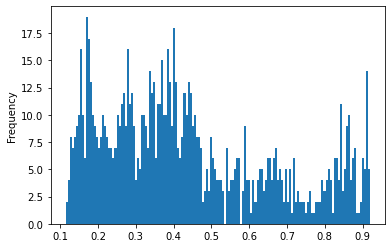

In [1341]:
final_prediction["probability"].plot.hist(bins=150)

In [1342]:
final_prediction.to_csv("prediction.csv", header=True, index=False)

In [1343]:
# Clients most likely to pay back loan are those with lowest probabilities of defaulting
final_prediction.sort_values("probability", ascending = True).head()

,ID,probability
575,17142,0.114955
611,18221,0.116323
87,2665,0.121726
185,5735,0.122132
980,29498,0.123595


Now suppose the bank wants to optimize the decision-making process by establishing the optimal threshold for the model in order to effectively take the decision about when to issue the credit and when not. So, taking into account the following numbers:

- A customer who received a loan but doesn't repay costs 5000 to the bank
- A customer who receives a loan and repays, make a profit of 1000 to the bank
- If the credit is not issued, then there is no profit or loss

To get an optimal threshold based on the validation set, I used my final model to make predictions on the validation set. This is done below.

In [54]:
# # Run Random Forest with Bagging for all 50 subsamples

# Create df to add predictions to
internal_predictions_df = test["ID"].to_frame()

for sample in balanced_samples:
    
    #Create X train
    X_train = sample.drop(columns=["DEFAULT_JULY", "ID"]) #Prepare X train
    
    #Create y train
    y_train = sample["DEFAULT_JULY"] #Prepare y train
    
    #Fit model
    model = BaggingClassifier(
        estimator=RandomForestClassifier(
            random_state=42,
            max_leaf_nodes=100,
            n_estimators=30,
            min_samples_leaf=1
        ),
        random_state=42
    ).fit(X_train, y_train)
    
    #Predict on test set
    internal_prediction = model.predict_proba(X_test) 
    
    #Reformat prediction & join with prediction dataframe created in section 6.3
    internal_prediction = pd.Series(internal_prediction[:,1],name="prob")
    internal_prediction = internal_prediction.to_frame()
    internal_prediction.reset_index(drop=True, inplace=True)
    internal_predictions_df = pd.concat([internal_predictions_df, internal_prediction], axis=1)

In [55]:
# X_test probabilities
internal_predictions_df["mean_prob"] = internal_predictions_df.iloc[:, 1:].mean(axis=1)

In [57]:
# Test score
roc_auc_score(y_test, internal_predictions_df["mean_prob"])

0.784763300113238

<AxesSubplot:ylabel='Frequency'>

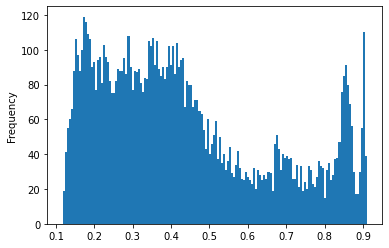

In [58]:
internal_predictions_df["mean_prob"].plot.hist(bins=150)

In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# gain and cost values
Gain_TP = 0
Cost_FP = 0 #-1000 depends on assignment instructions
Gain_TN = 1000
Cost_FN = -5000

# calculate predicted probabilities
y_pred_prob = internal_predictions_df["mean_prob"]

# calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

gain = 0
optimal_T = None

for T in thresholds:
    y_pred = (y_pred_prob >= T).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    new_gain = (tp * Gain_TP) + (fp * Cost_FP) + (tn * Gain_TN) + (fn * Cost_FN)
    
    if new_gain > gain:
        gain = new_gain
        optimal_T = T

# calculate confusion matrix for the optimal threshold
y_pred = (y_pred_prob >= optimal_T).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# calculate AUC for the optimal threshold
auc_score = auc(fpr, tpr)

print('Optimal Threshold:', optimal_T)
print('True Positive:', tp)
print('False Positive:', fp)
print('True Negative:', tn)
print('False Negative:', fn)
print('AUC:', auc_score)
print('Profit:', gain)

Optimal Threshold: 0.4530681883081557
True Positive: 1414
False Positive: 1984
True Negative: 5021
False Negative: 581
AUC: 0.784763300113238
Profit: 2116000
